# **General Matrix factorization**

In this piece of code, we make a model for our recommendation system with the help of the Collaborative Filtering method. Here, we have named the matrix factorization as General Matrix Factorization of GMF. 

Importing the necessary packages

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import plot_model

Reading the data and ignoring the *timestamp* and *category* columns and taking only the unique U_ID values from the dataset.

In [ ]:
col_list = ["U_ID", "P_ID", "RATING"]
dataset = pd.read_csv(r'rating.csv',usecols=col_list, sep='\t',dtype='int')

In [ ]:
#to get the unique user ids from dataset
user_ids = dataset['U_ID'].values
unique_ids = np.unique(user_ids)
id_dict = {id: counter for counter, id in enumerate(unique_ids)}
#enumerate(unique_ids)
dataset['U_ID'] = dataset['U_ID'].apply(lambda x: id_dict[x])

Taking the unique product ids from dataset

In [ ]:

product_ids = dataset['P_ID'].values
unique_ids = np.unique(product_ids)
#create a dictionary of users with key value from 0 to #users
id_dict = {id: counter for counter, id in enumerate(unique_ids)}
dataset['P_ID'] = dataset['P_ID'].apply(lambda x: id_dict[x])

Splitting the data into trainset and testset in a 4:1 ratio

In [ ]:

train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.U_ID.unique())
n_products = len(dataset.P_ID.unique())

### Model selection and readying the data

Here we define the layers, optimizers and metrics for the model to use.

In [ ]:
#Input() is used to instantiate a Keras tensor.
user_input = Input(shape=[1], name="User-Input")
#Embedding(input_dim,output_dim), here latent_factor for user is consider to be 5 
user_embedding = Embedding(n_users+1, 20, name="User-Embedding")(user_input)
#Flattening a tensor means to remove all of the dimensions except for one. This is exactly what the Flatten layer do.
user_vec = Flatten(name="Flatten-Users")(user_embedding)

In [ ]:
product_input = Input(shape=[1], name="Product-Input")
product_embedding = Embedding(n_products+1, 20, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Products")(product_embedding)

In [ ]:
#Layer that computes a dot product between samples in two tensors.
prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
#Model groups layers into an object with training and inference features.Model(input,output)
model = Model([user_input, product_input], prod)
#Configures the model for training.compile(optimizer, loss, metrics)
model.compile('adam', loss='mean_squared_error', metrics=['mae', 'mse'])

### Training the model
The model is trained on the trainset for a fixed number of epochs (iterations on a dataset).

In [ ]:
history = model.fit([train.U_ID, train.P_ID], train.RATING, epochs=10, verbose=1)
model.save('regression_model.h5')

Epoch 1/10
7103/7103 [==============================] - 155s 22ms/step - loss: 18.0541 - mae: 4.1090 - mse: 18.0541
Epoch 2/10
7103/7103 [==============================] - 156s 22ms/step - loss: 13.1508 - mae: 3.3514 - mse: 13.1508
Epoch 3/10
7103/7103 [==============================] - 155s 22ms/step - loss: 7.8624 - mae: 2.4103 - mse: 7.8624
Epoch 4/10
7103/7103 [==============================] - 155s 22ms/step - loss: 4.6069 - mae: 1.7405 - mse: 4.6069
Epoch 5/10
7103/7103 [==============================] - 161s 23ms/step - loss: 2.6630 - mae: 1.2673 - mse: 2.6630
Epoch 6/10
7103/7103 [==============================] - 158s 22ms/step - loss: 1.5493 - mae: 0.9404 - mse: 1.5493
Epoch 7/10
7103/7103 [==============================] - 155s 22ms/step - loss: 0.9391 - mae: 0.7213 - mse: 0.9391
Epoch 8/10
7103/7103 [==============================] - 153s 21ms/step - loss: 0.6228 - mae: 0.5850 - mse: 0.6228
Epoch 9/10
7103/7103 [==============================] - 152s 21ms/step - loss: 0.464

The train result is then plotted on a graph with X-axis as the *epoch number* and the Y-axis as the *training error*

Text(0, 0.5, 'Training Error')

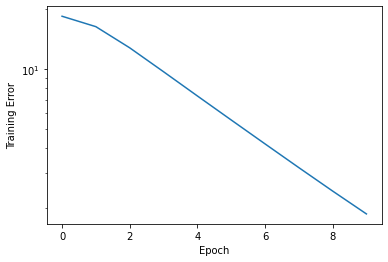

In [ ]:

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

Visualizing the model results as a table

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Product-Input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Product-Embedding (Embedding)   (None, 1, 5)         525575      Product-Input[0][0]              
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         36880       User-Input[0][0]                 
_______________________________________________________________________________________

Visualizing the model results to show the mappings

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Displaying theloss value & metrics values for the model in test mode.




In [ ]:
results = model.evaluate([test.U_ID, test.P_ID], test.RATING, batch_size=1)

56818/56818 [==============================] - 40s 700us/step - loss: 7.0950 - mae: 2.0650 - mse: 7.0950


In [ ]:
results

[7.095021724700928, 2.0649631023406982, 7.095021724700928]

Retrieves a layer based on either its name (unique) or index.

In [ ]:
#get_weights() Returns the current weights of the layer.
product_embedding_learnt = model.get_layer(name='Product-Embedding').get_weights()[0]
pd.DataFrame(product_embedding_learnt).describe()

,0,1,2,3,4
count,105115.000000,105115.000000,105115.000000,105115.000000,105115.000000
mean,-0.023154,-0.291382,0.250446,-0.282059,-0.208059
std,0.288352,0.209021,0.232196,0.213124,0.251514
min,-1.171740,-1.462382,-0.913866,-1.393721,-1.185616
25%,-0.284525,-0.363369,0.130080,-0.361387,-0.342909
50%,-0.011703,-0.290651,0.282425,-0.289203,-0.271254
75%,0.266721,-0.210694,0.354324,-0.203514,-0.027544
max,1.206606,0.835379,1.355952,0.868442,0.917778


In [ ]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]

**Param** *user_id*: The unique U_ID

**Param** *number_of_products*: (default = 5), The number of predictions to choose based on relevancy


In [ ]:
def recommend(user_id, number_of_products=5):
  products = user_embedding_learnt[user_id]@product_embedding_learnt.T
  mids = np.argpartition(products, -number_of_products)[-number_of_products:]
  return mids

Displaying recommendations

In [ ]:
recommend(user_id=1)

array([65285, 54908, 78052, 42177, 11872])

In [ ]:
recommend(user_id=600)

array([51016, 44311, 43112, 71816, 57659])